In [1]:
# Libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
import statsmodels.api as sm

In [2]:
# Load the data
df = pd.read_excel('/content/Sales Dataset.xlsx')
df.shape

(111570, 19)

In [3]:
# short data view
df.head(2)

,Restaurant Name,System Date,Order Type,Sales Channle,Order No,Customer Name,Order Start Time,Order End Time,Food ID,KSOP Reciepe Name,Food Name,Quantity,Food Category,FoodTypeName,Net Price,Total Discount Price,Tax Price,Total Price,Food Cost
0,Hamilton,2022-02-07,TAKEOUT,Take Outs,12552641,Customer 74,2023-01-01 10:02:02,2023-01-01 10:09:02,893,Food Name 1,Strawberry Sunrise,2,Namaste Kitchen,Category 19,5.588571,0.0,0.838286,6.426857,4.264514
1,Hamilton,2022-02-13,TAKEOUT,Take Outs,12552786,Customer 74,2022-09-21 20:56:55,2022-09-21 21:09:55,893,Food Name 1,Strawberry Sunrise,1,Namaste Kitchen,Category 19,9.285714,0.0,1.392857,10.678571,4.262686


# Data Cleaning:

1. Just by comparing each column to one another, I found out that the System Date, Order start, and End Time columns have some hidden mystery.
2. Later, I found out that the date in 'System Date' column does not match, that I decided to drop that column.

In [4]:
## Droping the 'System Date' - since it is meaning less
df.drop('System Date', axis=1, inplace=True)

In [5]:
## checking missing values
df.isna().sum()

,0
Restaurant Name,0
Order Type,0
Sales Channle,0
Order No,0
Customer Name,0
Order Start Time,0
Order End Time,0
Food ID,0
KSOP Reciepe Name,0
Food Name,0


- There are no missing values. So I am moving on to check dupplicate values.

In [6]:
## checking dupplicates
df[df.duplicated()].shape

(245, 18)

- since there are some duplicate values present in the data. So, I am dropping it.

In [7]:
## Remove duplicates
print("Before dropping duplicates", df.shape)
df = df.drop_duplicates().reset_index(drop=True)
print("After dropping duplicates", df.shape)

Before dropping duplicates (111570, 18)
After dropping duplicates (111325, 18)


In [8]:
## extract date and covert to datetime format
df['Daily Date'] = df['Order Start Time'].dt.date
df['Daily Date'] = pd.to_datetime(df['Daily Date'])
df['Order Start Time'] = pd.to_datetime(df['Order Start Time'])
df['Order End Time'] = pd.to_datetime(df['Order End Time'])

In [9]:
## Creating a Weekend column
def create_weekend_date_column(df, date_column, new_column_name='Weekend Date'):
    df[new_column_name] = pd.to_datetime(df[date_column]).dt.floor('d') - pd.to_timedelta((pd.to_datetime(df[date_column]).dt.weekday - 4) % 7, unit='D')
    return df

df = create_weekend_date_column(df, 'Daily Date')

In [10]:
## Create Shift Feature
def classify_shift(t):
    if pd.isnull(t):
        return 'unknown'

    # Extract hour from the Timestamp
    hour = t.hour

    if 10 <= hour < 14:
        return 'morning'
    elif 14 <= hour < 18:
        return 'midday'
    elif 18 <= hour <= 22:  # Changed to 22 for inclusive check
        return 'evening'
    return 'other'

df['Shift'] = df['Order Start Time'].apply(classify_shift)

In [11]:
## Change the column values to our understanding

## renaming order_type
order_type_mapping = {
    'Take Out': 'TAKEOUT',
    'TAKEOUT': 'TAKEOUT',
    'DELIVERY': 'DELIVERY',
    'TAB': 'TAKEOUT',
}

## Create a new column with standardized names
df['Renamed Order Type'] = df['Order Type'].replace(order_type_mapping)

In [12]:
## Calculating the time diff for an order to prepare
df['Order Time diff (Sec)'] = (df['Order End Time'] - df['Order Start Time']).dt.total_seconds()
df['Order Time diff (Min)'] = (df['Order End Time'] - df['Order Start Time']).dt.total_seconds() / 60

In [13]:
df.columns

Index(['Restaurant Name', 'Order Type', 'Sales Channle', 'Order No',
       'Customer Name', 'Order Start Time', 'Order End Time', 'Food ID',
       'KSOP Reciepe Name', 'Food Name', 'Quantity', 'Food Category',
       'FoodTypeName', 'Net Price', 'Total Discount Price', 'Tax Price',
       'Total Price', 'Food Cost', 'Daily Date', 'Weekend Date', 'Shift',
       'Renamed Order Type', 'Order Time diff (Sec)', 'Order Time diff (Min)'],
      dtype='object')

In [14]:
## Filtering basded on one restaurant name and one shift.
df = df[(df['Restaurant Name'] == 'Englewood') & (df['Shift'] == 'midday')].reset_index()

# Daily Data Exploration and Stationary check

In [15]:
## Daily date aggreation:
df1 = df.groupby(['Daily Date', 'Restaurant Name','Shift'])[['Order Time diff (Min)', 'Total Price']].sum().reset_index()

In [16]:
df1

,Daily Date,Restaurant Name,Shift,Order Time diff (Min),Total Price
0,2022-01-02,Englewood,midday,180.0,45.884657
1,2022-01-05,Englewood,midday,570.0,197.680171
2,2022-01-06,Englewood,midday,64.0,28.115857
3,2022-01-12,Englewood,midday,765.0,218.005371
4,2022-01-16,Englewood,midday,276.0,106.275143
...,...,...,...,...,...
120,2022-12-19,Englewood,midday,391.0,98.593943
121,2022-12-21,Englewood,midday,294.0,76.607800
122,2022-12-25,Englewood,midday,374.0,219.895057
123,2022-12-31,Englewood,midday,323.0,112.236743


In [17]:
## fill missing dates:
def missing_dates(df,date='Daily Date'):
  all_dates = pd.date_range(start=df[date].min(), end=df[date].max()) ## full range of dates
  existing_dates = set(df[date])
  missing_dates = sorted(set(all_dates) - existing_dates)
  df1 = pd.DataFrame({'Daily Date': missing_dates})
  df1['Restaurant Name'] = df['Restaurant Name'][0]
  df1['Shift'] = df['Shift'][0]
  df2 = pd.concat([df, df1], ignore_index=True)
  df2.fillna(df2[['Order Time diff (Min)',	'Total Price']].mean(), inplace=True)
  df2.sort_values(by='Daily Date', inplace=True)
  df2 = df2.reset_index(drop=True)
  return df2

In [18]:
df1 = missing_dates(df1,date='Daily Date')

In [19]:
df1.head()

,Daily Date,Restaurant Name,Shift,Order Time diff (Min),Total Price
0,2022-01-02,Englewood,midday,180.000,45.884657
1,2022-01-03,Englewood,midday,537.064,186.013248
2,2022-01-04,Englewood,midday,537.064,186.013248
3,2022-01-05,Englewood,midday,570.000,197.680171
4,2022-01-06,Englewood,midday,64.000,28.115857


## Data Stationary Check

**Step 1:** Augmented Dickey-Fuller (ADF) Test
- H0 (null hypothesis) -> data is not stationary (Pvalue >0.05) (test statistic has to be  has to positive)
- H1 (alternate hypothesis) -> data is stationary (Pvalue <=0.05) (test statistic has to be more negative)
- Formula: 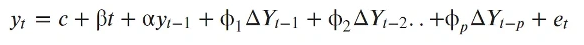


In [20]:
check_df1 = df1.copy() # create a copy for the test
check_df1.index = check_df1['Daily Date'] # making the date into index
check_df1.drop('Daily Date', axis=1, inplace=True) # drop the date in check_df1

# Function to print out results in customised manner
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
# Call the function and run the test

adf_test(check_df1['Total Price'])

Results of Dickey-Fuller Test:
Test Statistic                -1.741386e+01
p-value                        4.868649e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.640000e+02
Critical Value (1%)           -3.448443e+00
Critical Value (5%)           -2.869513e+00
Critical Value (10%)          -2.571018e+00
dtype: float64


- According to the test, ADF is successful, and H0 (null hypothesis) is passed. so, that the data is stationary.

<Axes: xlabel='Daily Date'>

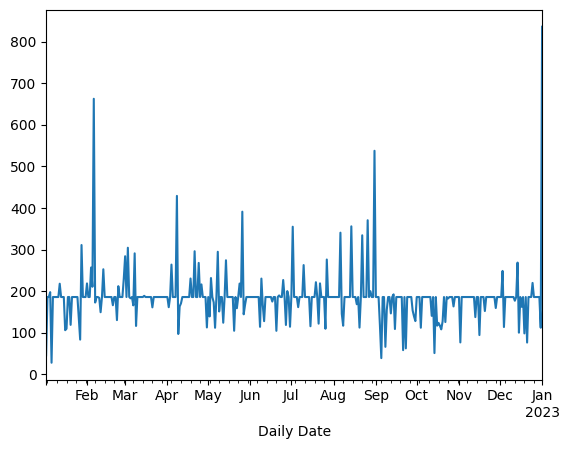

In [21]:
check_df1['Total Price'].plot()

**Step2:** Outlier Check basecdx on Z score:

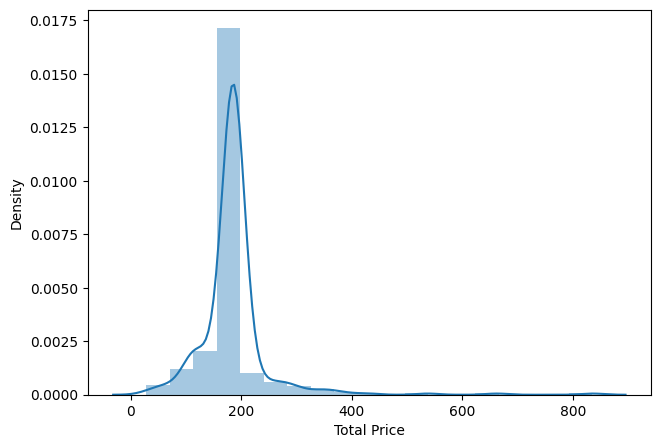

In [22]:
## dist plot to find the stage 1 outlier
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df1['Total Price'])
plt.show()

In [23]:
df1['Total Price'].median()

186.01324754285713

In [24]:
## Finding the boundary values
print("Highest allowed",df1['Total Price'].mean() + 3*df1['Total Price'].std())
print("Lowest allowed",df1['Total Price'].mean() - 3*df1['Total Price'].std())

Highest allowed 380.9050919117511
Lowest allowed -8.878596826036699


In [25]:
## outlier entries
df1[(df1['Total Price'] > 380.90) | (df1['Total Price'] < -8.87)]

,Daily Date,Restaurant Name,Shift,Order Time diff (Min),Total Price
35,2022-02-06,Englewood,midday,2898.0,662.504229
96,2022-04-08,Englewood,midday,941.0,429.085914
144,2022-05-26,Englewood,midday,908.0,391.136714
241,2022-08-31,Englewood,midday,1068.0,537.500543
364,2023-01-01,Englewood,midday,1979.0,835.680629


In [26]:
## non-outlier entries
df1[(df1['Total Price'] < 380.90) & (df1['Total Price'] >= -8.87)]

,Daily Date,Restaurant Name,Shift,Order Time diff (Min),Total Price
0,2022-01-02,Englewood,midday,180.000,45.884657
1,2022-01-03,Englewood,midday,537.064,186.013248
2,2022-01-04,Englewood,midday,537.064,186.013248
3,2022-01-05,Englewood,midday,570.000,197.680171
4,2022-01-06,Englewood,midday,64.000,28.115857
...,...,...,...,...,...
359,2022-12-27,Englewood,midday,537.064,186.013248
360,2022-12-28,Englewood,midday,537.064,186.013248
361,2022-12-29,Englewood,midday,537.064,186.013248
362,2022-12-30,Englewood,midday,537.064,186.013248


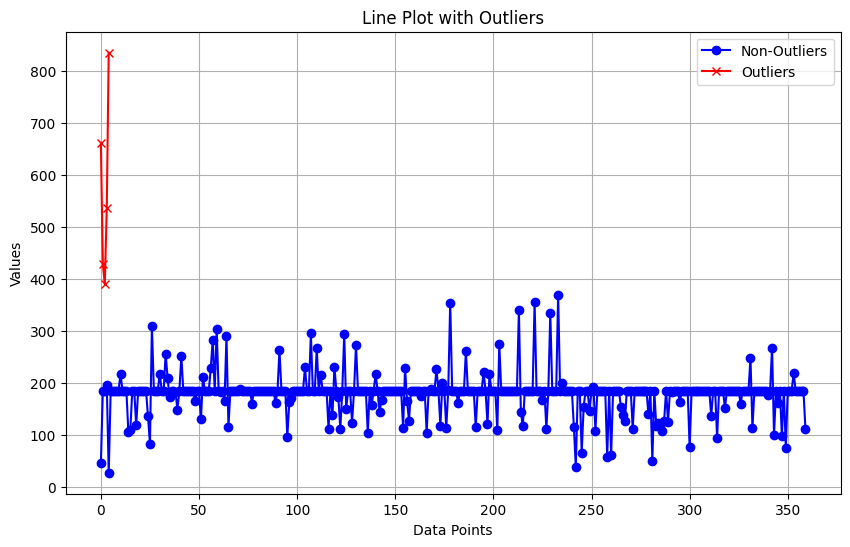

In [27]:
outliers = df1[(df1['Total Price'] > 380.90) | (df1['Total Price'] < -8.87)]['Total Price']
non_outliers = df1[(df1['Total Price'] < 380.90) & (df1['Total Price'] >= -8.87)]['Total Price']

# Plot the line plot with outliers highlighted
plt.figure(figsize=(10, 6))
plt.plot(range(len(non_outliers)), non_outliers, marker='o', linestyle='-', color='blue', label='Non-Outliers')
plt.plot(range(len(outliers)), outliers, marker='x', linestyle='-', color='red', label='Outliers')
plt.title('Line Plot with Outliers')
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

- Now I found out the outliers. so, I am doing median imputation on all 5 values.

In [28]:
## median imputation on outlier values
median_value = non_outliers.median()
df1.loc[(df1['Total Price'] > 380.90) | (df1['Total Price'] < -8.87), 'Total Price'] = median_value

## Feature Engineering

In [29]:
# Feature Engineering: Create lag and moving average features
df1['Sales_Lag_1day'] = df1['Total Price'].shift(1)
df1['Sales_Lag_2days'] = df1['Total Price'].shift(2)
df1['Sales_Lag_3days'] = df1['Total Price'].shift(3)
df1['Sales_Lag_4days'] = df1['Total Price'].shift(4)
df1['Sales_Lag_5days'] = df1['Total Price'].shift(5)
df1['Sales_Lag_6days'] = df1['Total Price'].shift(6)
df1['Sales_Lag_7days'] = df1['Total Price'].shift(7)
df1['Sales_Daily_Diff'] = df1['Total Price'] - df1['Sales_Lag_1day']
df1['Sales_2day_MA'] = df1['Total Price'].rolling(window=2).mean()
df1['Sales_3day_MA'] = df1['Total Price'].rolling(window=3).mean()
df1['Sales_4day_MA'] = df1['Total Price'].rolling(window=4).mean()
df1['Sales_5day_MA'] = df1['Total Price'].rolling(window=5).mean()
df1['Sales_6day_MA'] = df1['Total Price'].rolling(window=6).mean()
df1['Sales_7day_MA'] = df1['Total Price'].rolling(window=7).mean()

## filling nan with 0
df1.fillna(0, inplace=True)

In [30]:
df1.head()

,Daily Date,Restaurant Name,Shift,Order Time diff (Min),Total Price,Sales_Lag_1day,Sales_Lag_2days,Sales_Lag_3days,Sales_Lag_4days,Sales_Lag_5days,Sales_Lag_6days,Sales_Lag_7days,Sales_Daily_Diff,Sales_2day_MA,Sales_3day_MA,Sales_4day_MA,Sales_5day_MA,Sales_6day_MA,Sales_7day_MA
0,2022-01-02,Englewood,midday,180.000,45.884657,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,2022-01-03,Englewood,midday,537.064,186.013248,45.884657,0.000000,0.000000,0.000000,0.0,0.0,0.0,140.128590,115.948952,0.000000,0.000000,0.000000,0.0,0.0
2,2022-01-04,Englewood,midday,537.064,186.013248,186.013248,45.884657,0.000000,0.000000,0.0,0.0,0.0,0.000000,186.013248,139.303717,0.000000,0.000000,0.0,0.0
3,2022-01-05,Englewood,midday,570.000,197.680171,186.013248,186.013248,45.884657,0.000000,0.0,0.0,0.0,11.666924,191.846709,189.902222,153.897831,0.000000,0.0,0.0
4,2022-01-06,Englewood,midday,64.000,28.115857,197.680171,186.013248,186.013248,45.884657,0.0,0.0,0.0,-169.564314,112.898014,137.269759,149.455631,128.741436,0.0,0.0


## PCA

In [31]:
df1.columns

Index(['Daily Date', 'Restaurant Name', 'Shift', 'Order Time diff (Min)',
       'Total Price', 'Sales_Lag_1day', 'Sales_Lag_2days', 'Sales_Lag_3days',
       'Sales_Lag_4days', 'Sales_Lag_5days', 'Sales_Lag_6days',
       'Sales_Lag_7days', 'Sales_Daily_Diff', 'Sales_2day_MA', 'Sales_3day_MA',
       'Sales_4day_MA', 'Sales_5day_MA', 'Sales_6day_MA', 'Sales_7day_MA'],
      dtype='object')

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Separate features (excluding target and non-numeric columns)
X = df1.drop(columns=['Daily Date', 'Restaurant Name', 'Shift', 'Total Price'])

# 2. Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Apply PCA with 5 components
pca = PCA(n_components=9)
X_pca = pca.fit_transform(X_scaled)

# 4. Explained variance per component
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# 5. Select components that contribute to 98% variance
n_selected_pcs = np.argmax(cumulative_var >= 0.98) + 1

print(f"✅ Total explained variance by first {n_selected_pcs} components: {cumulative_var[n_selected_pcs-1]:.4f}")

# 6. Get PCA loadings (feature weights per component)
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(9)],
                        index=X.columns)

# 7. Compute overall contribution of each feature to the selected PCs
abs_loadings = loadings.iloc[:, :n_selected_pcs].abs()
feature_contributions = abs_loadings.sum(axis=1).sort_values(ascending=False)

# 8. Get top 4 or 5 most important features
top_features = feature_contributions.head(9).index.tolist()  # change to head(4) if you prefer 4

# 9. Print result
print("\n📌 Top contributing features to the first PCs (up to 98% variance):")
for feature in top_features:
    print(f"- {feature}")


✅ Total explained variance by first 9 components: 0.9900

📌 Top contributing features to the first PCs (up to 98% variance):
- Order Time diff (Min)
- Sales_Lag_4days
- Sales_Lag_5days
- Sales_Lag_3days
- Sales_Lag_7days
- Sales_Lag_6days
- Sales_Lag_2days
- Sales_2day_MA
- Sales_Daily_Diff


In [33]:
cumulative_var

array([0.43978514, 0.563108  , 0.66415571, 0.73563202, 0.79967564,
       0.85679027, 0.90880488, 0.95837599, 0.99003488])

In [34]:
new_df1 = df1[['Daily Date', 'Order Time diff (Min)', 'Sales_Lag_2days', 'Sales_Lag_3days', 'Sales_Lag_4days', 'Sales_Lag_5days', 'Sales_Lag_6days', 'Sales_Lag_7days', 'Sales_Daily_Diff', 'Sales_2day_MA', 'Total Price']]
new_df1.head()

,Daily Date,Order Time diff (Min),Sales_Lag_2days,Sales_Lag_3days,Sales_Lag_4days,Sales_Lag_5days,Sales_Lag_6days,Sales_Lag_7days,Sales_Daily_Diff,Sales_2day_MA,Total Price
0,2022-01-02,180.000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,45.884657
1,2022-01-03,537.064,0.000000,0.000000,0.000000,0.0,0.0,0.0,140.128590,115.948952,186.013248
2,2022-01-04,537.064,45.884657,0.000000,0.000000,0.0,0.0,0.0,0.000000,186.013248,186.013248
3,2022-01-05,570.000,186.013248,45.884657,0.000000,0.0,0.0,0.0,11.666924,191.846709,197.680171
4,2022-01-06,64.000,186.013248,186.013248,45.884657,0.0,0.0,0.0,-169.564314,112.898014,28.115857


In [35]:
## Save file
new_df1.to_excel("Cleaned_Sales_Data.xlsx")